> This notebook implements a neural network to reproduce the results presented in the Example 1 of the paper `System Identification and Control Using Quadratic Neural Networks`.

## Example 1:
We perform system identification of a flexible robot arm nonlinear autoregressive model with `n = 1`. The data is available at the website of the Database for the Identification of Systems (DaISy) [15].
The applied input was a periodic sine sweep for which an output consisting of `N = 1024` data points was collected. The training was done for a quadratic activation function with parameters `a = 0.0937, b = 0.5, c = 0.4688`, using a regularization
coefficient of `β = 0.01` and an infinity norm loss function `l(.)`. Only the first 122 data points (12% of all data) were used to train the neural network.

[15] B. D. Moor, P. D. Gersem, B. D. Schutter, and W. Favoreel, “Daisy: A database for identification of systems,” Journal A, vol. 38, no. 3, pp. 4–5, 1997.

## Python Packages

In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

In [2]:
plt.rcParams['figure.dpi'] = 150

In [3]:
tag = datetime.now()
tag = tag.strftime("%Y-%m-%d-%H-%M-%S")

## Loading Data

__Data description:__ Data from a flexible robot arm. The arm is installed on an electrical motor.  We have modeled the transfer function from the measured reaction torque of the structure on the ground to the acceleration of the flexible arm.  The applied input is a periodic sine sweep. 

__Sampling number:__ `1024`

__Inputs:__ `u`: reaction torque of the structure

__Outputs:__ `y`: accelaration of the flexible arm

\
Let's use `numpy` to read the data and store it as a matrix.

In [4]:
data = np.loadtxt('../data/robot_arm.dat')

Confirm if the matrix has `1024` rows and `2` columns.

In [5]:
data.shape

(1024, 2)

Let's plot the data to see how it looks like.

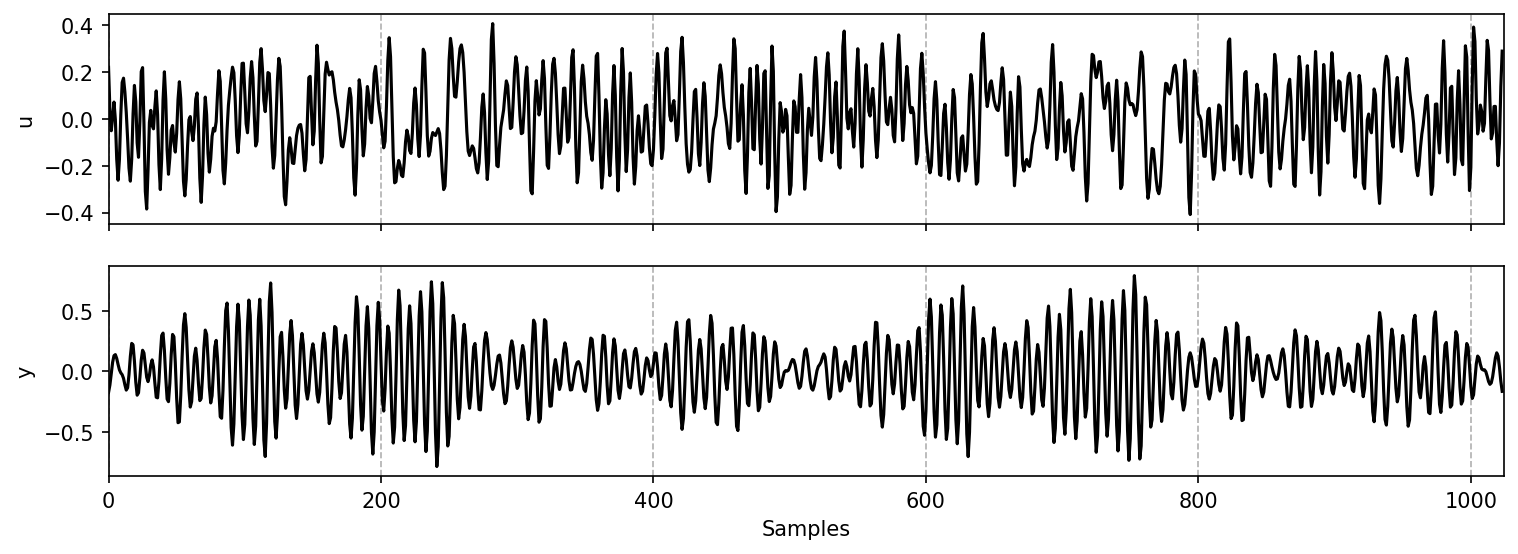

In [6]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,4), sharex=True)
ax1.plot(data[:,0],'-k', label='input')
ax2.plot(data[:,1],'-k', label='output')
ax1.grid(linestyle='--', axis='x')
ax2.grid(linestyle='--', axis='x')
ax1.set_xlim([0, 1024])
ax2.set_xlabel('Samples')
ax1.set_ylabel('u')
ax2.set_ylabel('y')
plt.show();

## Preparing dataset

Let's split the data into two sets for training and validation.

In [7]:
M = 512
train_set = data[:min(M,data.shape[0]),:]
valid_set = data[min(M,data.shape[0]):,:]

In [8]:
train_set.shape, valid_set.shape

((512, 2), (512, 2))

Let's see the portions selected for it task.

In [9]:
s = np.arange(0,1024,1)

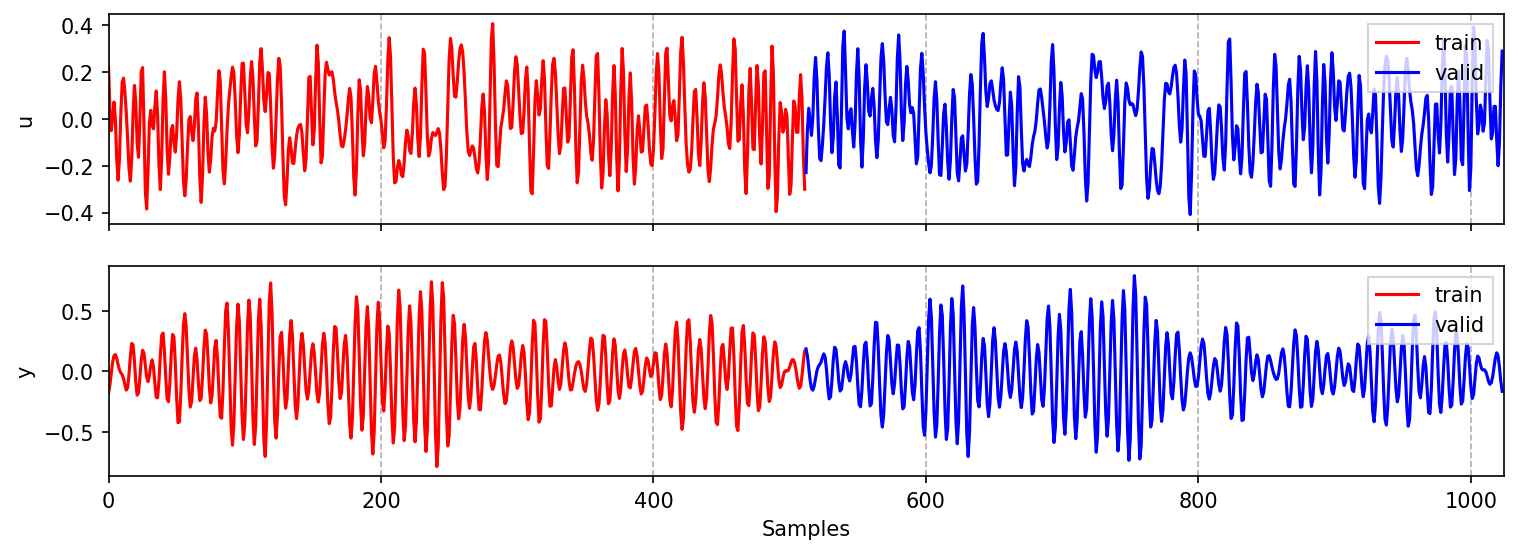

In [10]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,4), sharex=True)
ax1.plot(s[:train_set.shape[0]], train_set[:,0],'-r', label='train')
ax1.plot(s[train_set.shape[0]:], valid_set[:,0],'-b', label='valid')
ax2.plot(s[:train_set.shape[0]], train_set[:,1],'-r', label='train')
ax2.plot(s[train_set.shape[0]:], valid_set[:,1],'-b', label='valid')
ax1.grid(linestyle='--', axis='x')
ax2.grid(linestyle='--', axis='x')
ax1.set_xlim([0,1024])
ax1.legend(loc='upper right', fancybox=False)
ax2.legend(loc='upper right', fancybox=False)
ax2.set_xlabel('Samples')
ax1.set_ylabel('u')
ax2.set_ylabel('y')
plt.show();

Now, let's create a Pytorch custom dataset object to manage our data.

In [11]:
class MyDataset(Dataset):
    
    def __init__(self, data=None, n=1):
        super(MyDataset, self).__init__()
        self.n = n
        self.data = data
        
        
    def __len__(self):
        return self.data.shape[0]-self.n
    
    
    def __getitem__(self, id):
        u_curr = self.data[id+self.n, 0]
        y_prev = self.data[id:id+self.n, 1].tolist()
        y_curr = self.data[id+self.n, 1]
        
        input_  = [u_curr, *y_prev]
        output_ = [y_curr]
        
        input_  = torch.FloatTensor(input_)
        output_ = torch.FloatTensor(output_)
        
        return input_, output_

In [12]:
n = 1

In [13]:
train_dataset = MyDataset(data=train_set, n=n)

We can test the dataset object to see how the outputs look like:

In [14]:
# next(iter(train_dataset))

In [15]:
valid_dataset = MyDataset(data=valid_set, n=n)

Let's create the Dataloader that will take care of the dataset. It is responsible for minibatch strategies, sorting, etc.

To train the model using the whole training set, the user can use: $\text{batch_size} = M - n$. For minibatch, the user can use $\text{batch_size} < M - n$

In [16]:
batch_size = M-n

In [17]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)

In [18]:
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, drop_last=False, shuffle=False)

## Preparing the model

The input of the model is a factor of `n`. However, the output is a single number, i.e. $y_t$. Also, the user can control the size of the hidden layer.

In [19]:
class MyModel(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(MyModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.network = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size, bias=True),
            nn.ReLU(),
            nn.Linear(self.hidden_size, 1, bias=True)
        )
        
    def forward(self, x):
        y = self.network(x)
        return y

## Training the model

First, let's create some functions to help with some tasks.

In [20]:
def train_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0.
    for input_, output_ in dataloader:
        input_  = input_.to(device=device)
        output_ = output_.to(device=device)
        y = model(input_)
        loss = loss_fn(output_, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(dataloader.dataset)

In [21]:
def valid_epoch(model, dataloader, loss_fn, device):
    model.eval()
    valid_loss = 0.
    with torch.no_grad():
        for input_, output_ in dataloader:
            input_  = input_.to(device=device)
            output_ = output_.to(device=device)
            y = model(input_)
            loss = loss_fn(output_, y)
            valid_loss += loss.item()
    return valid_loss / len(dataloader.dataset)

In [22]:
def preview(model, dataloader, device):
    model.eval()
    ref = []
    est = []
    with torch.no_grad():
        for input_, output_ in dataloader:
            input_  = input_.to(device=device)
            output_ = output_.to(device=device)
            y = model(input_)
            ref.extend(output_.cpu().numpy().flatten().tolist())
            est.extend(y.cpu().numpy().flatten().tolist())
            
    fig, ax = plt.subplots(figsize=[12, 2])
    ax.plot(est, 'b', linewidth=1, label='y_hat')
    ax.plot(ref, 'or', markersize=1, label='y')
    ax.set_xlabel('Samples')
    ax.legend(loc='upper left', fancybox=False)
    ax.set_xlim([0, len(dataloader.dataset)])
    plt.grid(linestyle=':')
    plt.show()
    plt.close(fig)        
    return None

In [23]:
def loss_fn(y, y_hat):
    return torch.linalg.vector_norm(y-y_hat, ord=np.inf)

We can proceed with the main loop.

In [24]:
hidden_size = 100

In [25]:
model = MyModel(input_size=n+1, hidden_size=hidden_size)

Let's check some information about the model.

In [26]:
summary(model, input_size=[1,n+1])

/home/paulo/.pyenv/versions/venv.3.10.11/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/home/paulo/.pyenv/versions/venv.3.10.11/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 100]                  300
│    └─ReLU: 2-2                         [1, 100]                  --
│    └─Linear: 2-3                       [1, 1]                    101
Total params: 401
Trainable params: 401
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [28]:
model.to(device);

In [29]:
optimizer = optim.Adam(model.parameters(), lr=4e-2, weight_decay=1e-2)

In [30]:
epochs = 1000

In [31]:
train_losses = []

In [32]:
valid_losses = []

EPOCH 1/1000 	 TRAIN LOSS: 0.001806 	 TEST LOSS: 0.002352 	 TIME: 0.018 sec


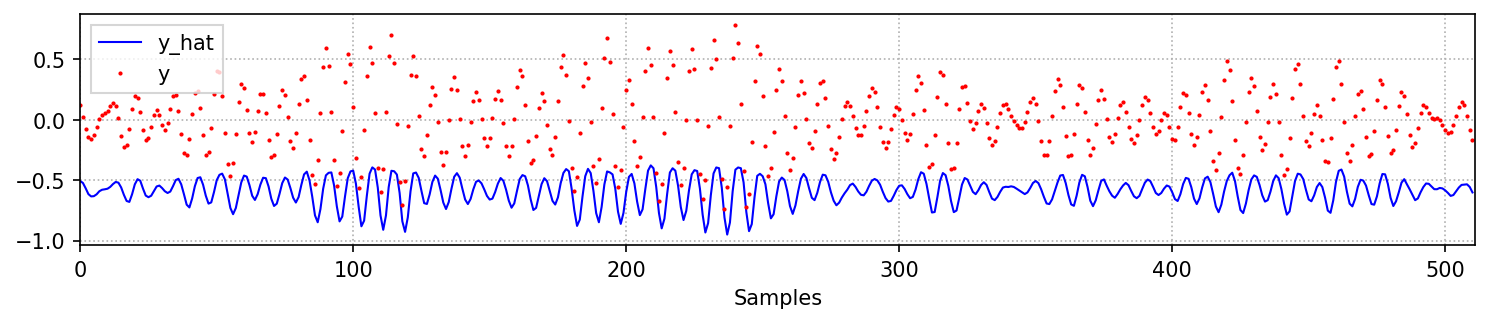

EPOCH 101/1000 	 TRAIN LOSS: 0.001039 	 TEST LOSS: 0.001042 	 TIME: 0.008 sec


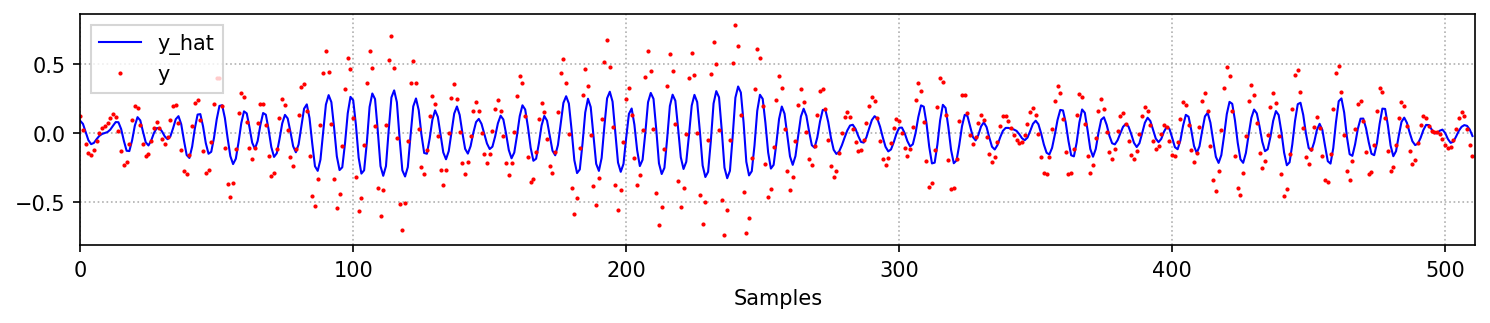

EPOCH 201/1000 	 TRAIN LOSS: 0.001066 	 TEST LOSS: 0.001051 	 TIME: 0.009 sec


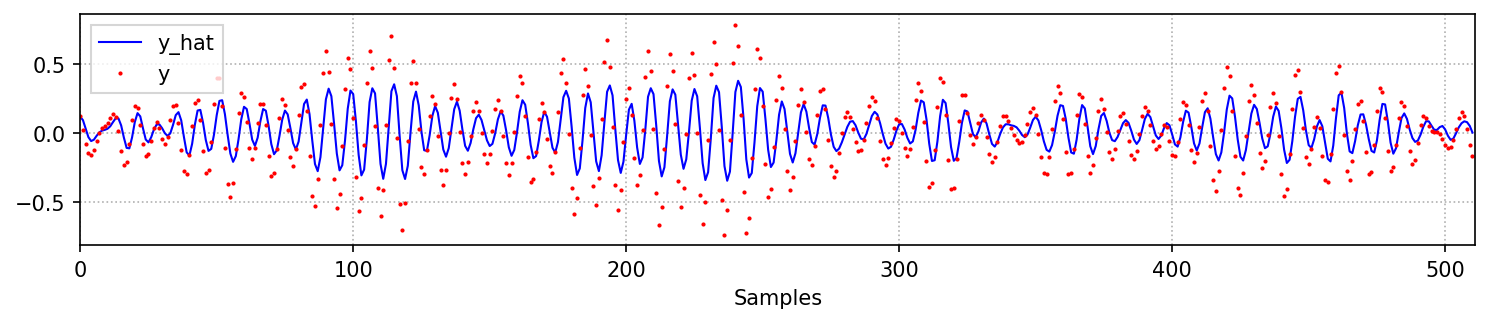

EPOCH 301/1000 	 TRAIN LOSS: 0.001036 	 TEST LOSS: 0.001134 	 TIME: 0.008 sec


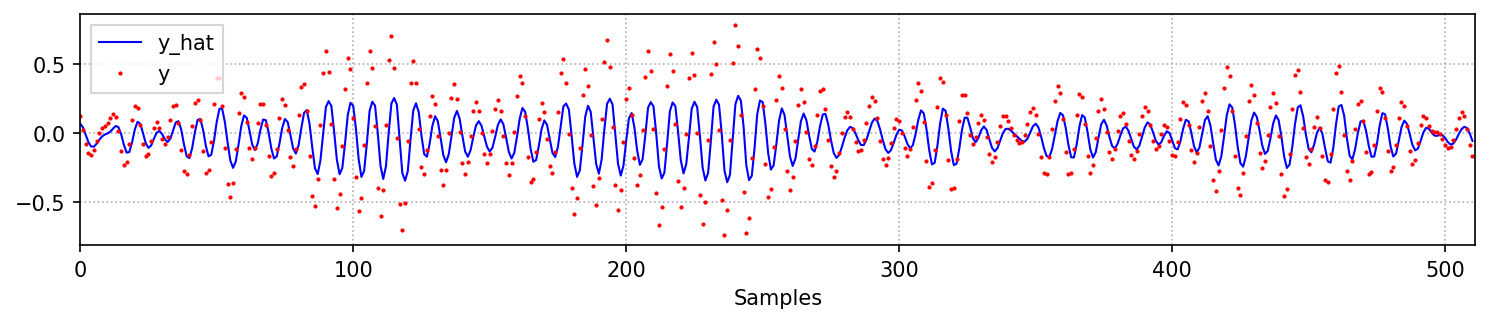

EPOCH 401/1000 	 TRAIN LOSS: 0.001044 	 TEST LOSS: 0.001051 	 TIME: 0.008 sec


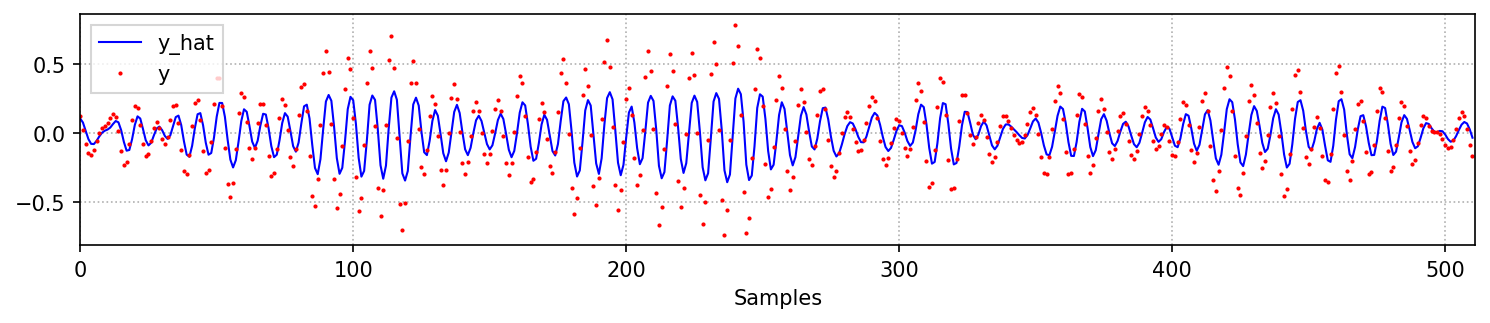

EPOCH 501/1000 	 TRAIN LOSS: 0.001043 	 TEST LOSS: 0.00107 	 TIME: 0.008 sec


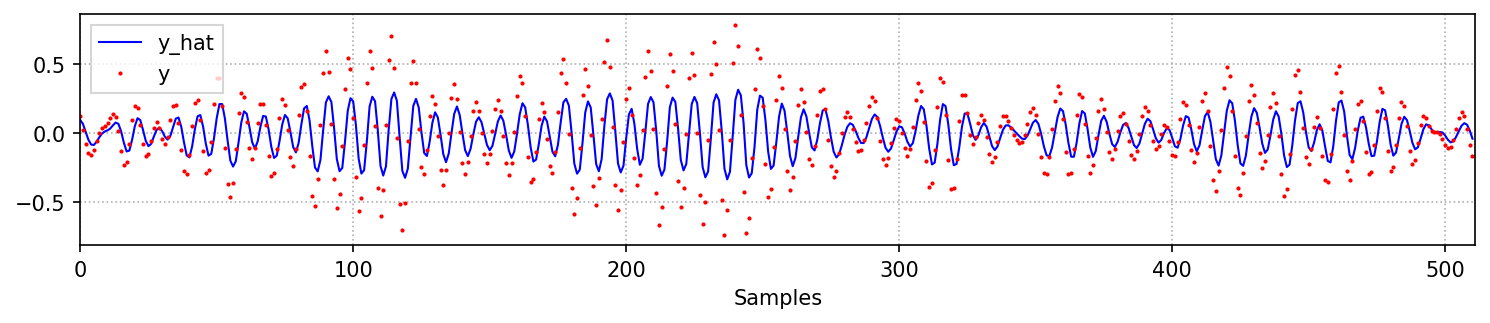

EPOCH 601/1000 	 TRAIN LOSS: 0.001036 	 TEST LOSS: 0.001072 	 TIME: 0.008 sec


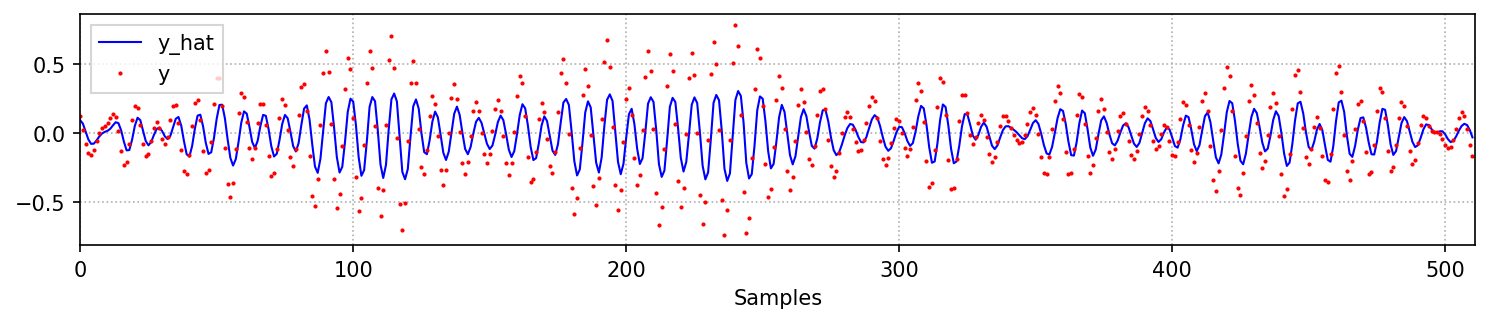

EPOCH 701/1000 	 TRAIN LOSS: 0.001097 	 TEST LOSS: 0.001126 	 TIME: 0.008 sec


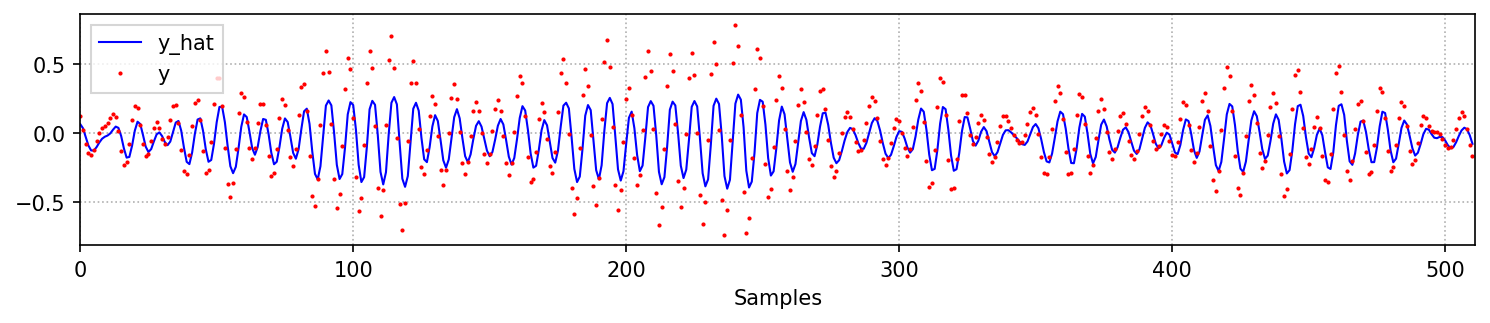

EPOCH 801/1000 	 TRAIN LOSS: 0.001043 	 TEST LOSS: 0.001036 	 TIME: 0.008 sec


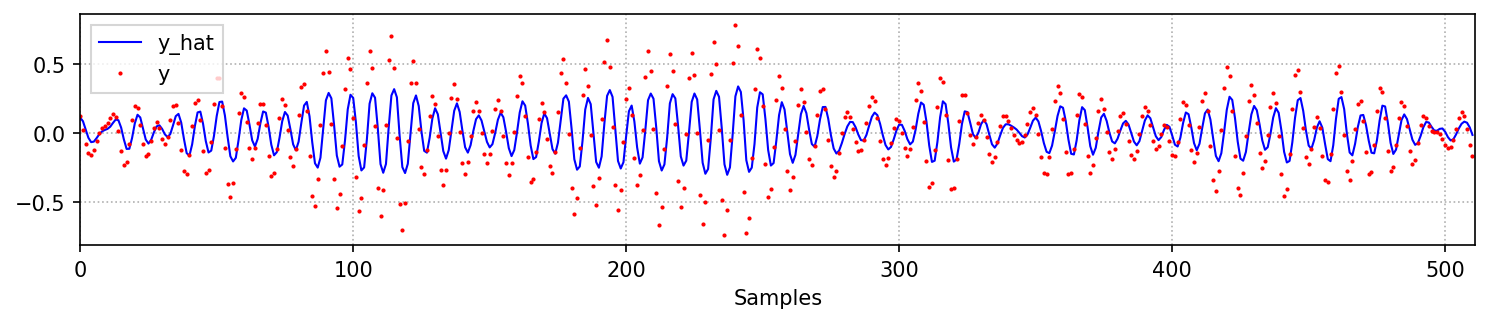

EPOCH 901/1000 	 TRAIN LOSS: 0.001066 	 TEST LOSS: 0.001113 	 TIME: 0.008 sec


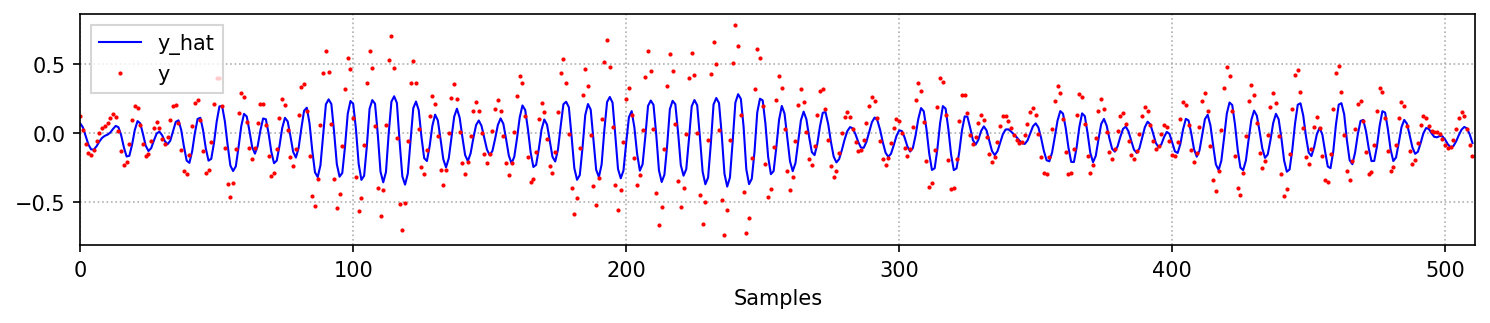

Total training time: 0.164min


In [33]:
init = time.time()
best_loss = np.inf

for epoch in range(epochs):
    tic = time.time()
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    valid_loss  = valid_epoch(model, valid_loader, loss_fn, device)
    toc = time.time()
            
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Previewing test data
    if epoch % 100 == 0:
        print(f'EPOCH {epoch+1}/{epochs} \t TRAIN LOSS: {round(train_loss,6)} \t TEST LOSS: {round(valid_loss,6)} \t TIME: {round((toc-tic),3)} sec')
        preview(model, valid_loader, device)
        
    # Saving best weights
    if valid_loss < best_loss:
        best_loss = valid_loss
        
        torch.save({
            'epoch':epoch,
            'valid_loss':valid_loss,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict()
        }, '../checkpoints/' + tag + '-weights.pt')

endd = time.time()
print(f'Total training time: {round((endd-init)/60,3)}min')

torch.save({'train_losses':train_losses,'valid_losses':valid_losses}, '../checkpoints/' + tag + '-losses.pt')

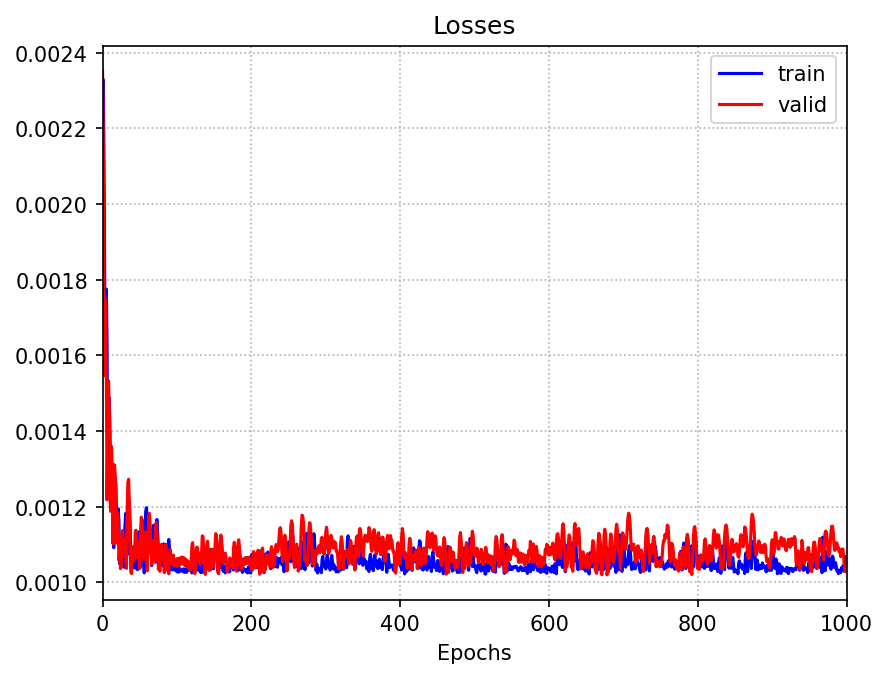

In [34]:
plt.plot(train_losses,'b',label='train')
plt.plot(valid_losses,'r',label='valid')
plt.legend()
plt.title('Losses')
plt.xlabel('Epochs')
plt.xlim([0,epochs])
plt.grid(linestyle=':')
plt.show();

## Checking best model

In [35]:
pretrained = torch.load('../checkpoints/' + tag + '-weights.pt')
model.load_state_dict(pretrained['model_state_dict'])

<All keys matched successfully>

In [36]:
model.eval();

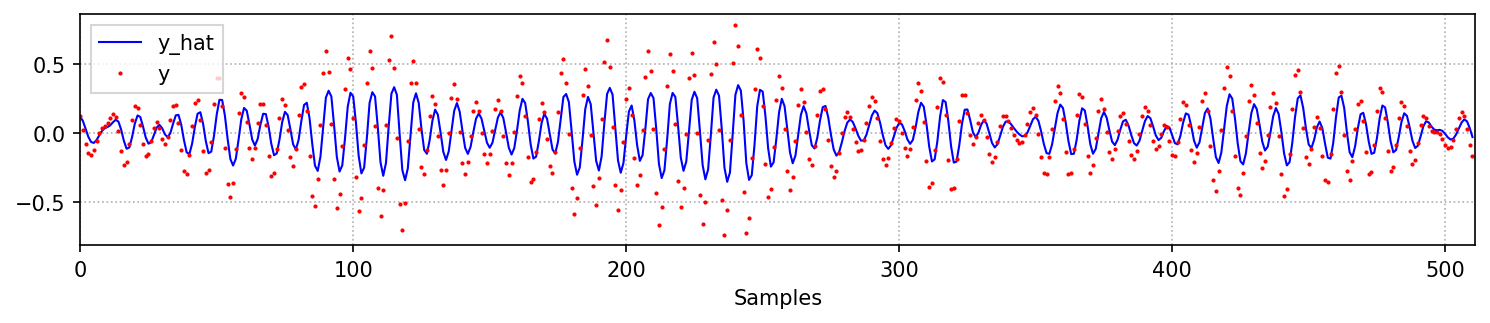

In [37]:
preview(model, valid_loader, device)